In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#Data Loading
import sys,os
sys.path.append(os.path.abspath(".."))
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split

train_df=pd.read_csv("../data/train_data.csv")
valid_df=pd.read_csv("../data/valid_data.csv")

from scripts.data_cleaning import clean_text
if "clean_text" not in train_df.columns:
    train_df["clean_text"]=train_df["text"].astype(str).apply(clean_text)
    valid_df["clean_text"]=valid_df["text"].astype(str).apply(clean_text)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)


X_train_tfidf=tfidf.fit_transform(train_df["clean_text"])
X_valid_tfidf=tfidf.transform(valid_df["clean_text"])

y_train=train_df["label"]
y_valid=valid_df["label"]

print("TF-IDF Feature Shape: ", X_train_tfidf.shape,X_valid_tfidf.shape)

[nltk_data] Downloading package stopwords to C:\Users\Sameer
[nltk_data]     Tripathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TF-IDF Feature Shape:  (16990, 5000) (4117, 5000)



 Logistic Regression Performence
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        73
           1       0.81      0.81      0.81       214
           2       0.85      0.74      0.79       852
           3       0.77      0.81      0.78        77
           4       0.95      0.99      0.97        97
           5       0.94      0.93      0.93       242
           6       0.67      0.86      0.75       146
           7       0.84      0.85      0.85       160
           8       0.65      0.81      0.72        32
           9       0.65      0.69      0.67       336
          10       0.33      0.77      0.47        13
          11       0.78      1.00      0.88        14
          12       0.77      0.89      0.82       119
          13       0.70      0.78      0.74       116
          14       0.80      0.71      0.75       415
          15       0.71      0.81      0.76       125
          16       0.87      0.89      0.88    

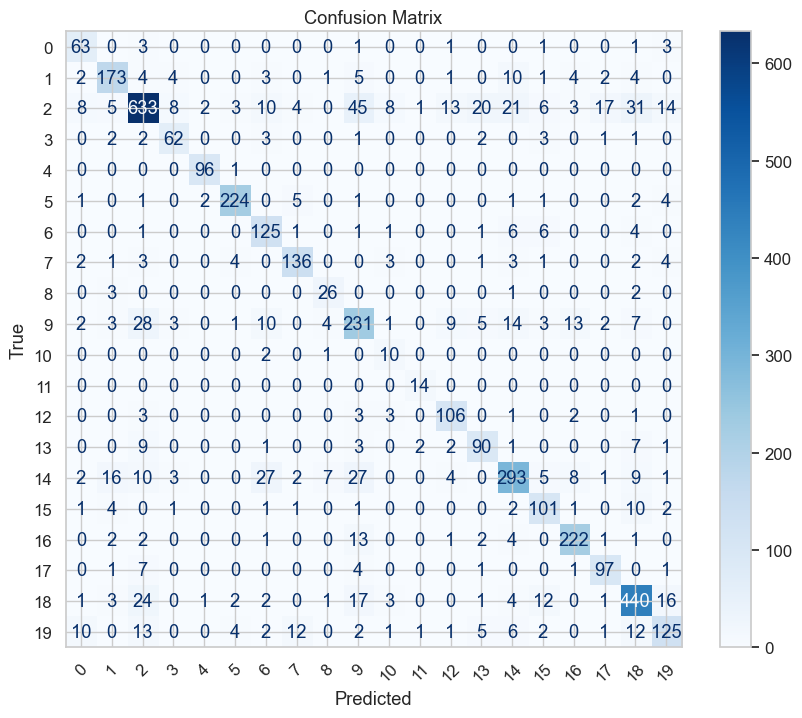

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from scripts.visualization import plot_confusion_matrix

lr_model=LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr=lr_model.predict(X_valid_tfidf)
y_proba=lr_model.predict_proba(X_valid_tfidf)

print("\n Logistic Regression Performence")
print(classification_report(y_valid, y_pred_lr))

plot_confusion_matrix(y_valid, y_pred_lr)

In [4]:
with open("../models/logistic_regression.pkl", "wb") as f:
    pickle.dump(lr_model, f)

print("Logsitic Regression model saved.")

Logsitic Regression model saved.


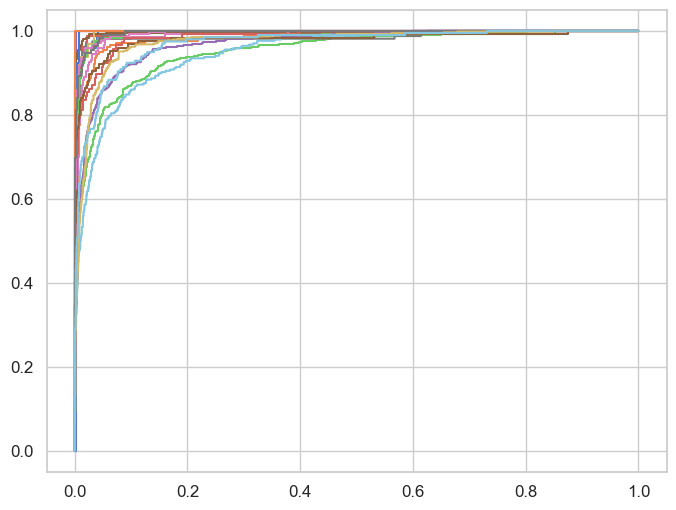

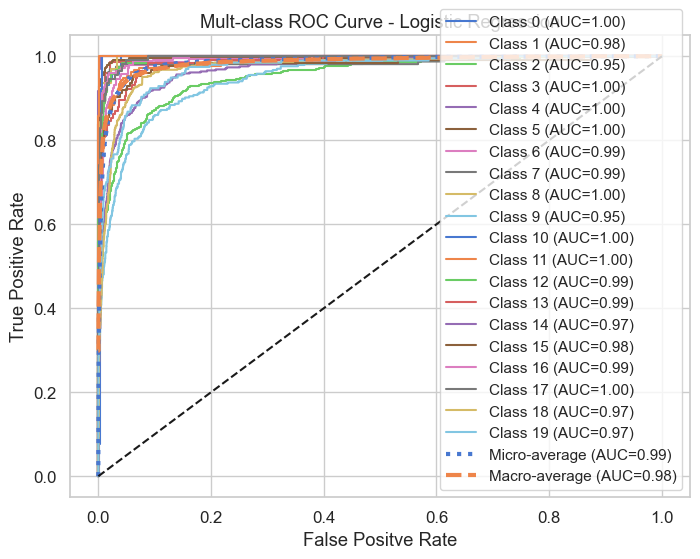

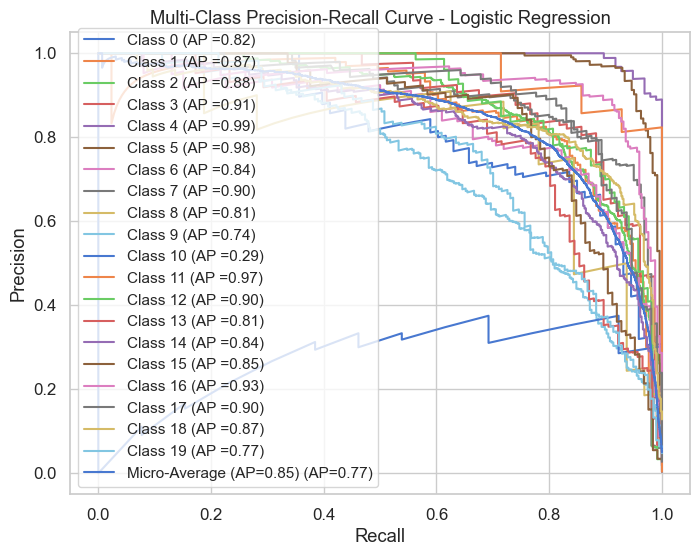

In [5]:
# ROC-AUC 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_valid_bin=label_binarize(y_valid, classes=lr_model.classes_)
n_classes=y_valid_bin.shape[1]

#Multi class ROC Curves
fpr=dict()
tpr=dict()
roc_auc=dict()

for i in range(n_classes):
    fpr[i],tpr[i],_=roc_curve(y_valid_bin[:,i],y_proba[:,i])
    roc_auc[i]=auc(fpr[i], tpr[i])


#Micro-Average ROC
fpr["micro"], tpr["micro"], _=roc_curve(y_valid_bin.ravel(), y_proba.ravel())
roc_auc["micro"]=auc(fpr["micro"], tpr["micro"])

#Macro-Average ROC
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr=np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr+=np.interp(all_fpr,fpr[i],tpr[i])
mean_tpr/=n_classes
fpr["macro"]=all_fpr
tpr["macro"]=mean_tpr
roc_auc["macro"]=auc(fpr["macro"], tpr["macro"])

#ROC curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {lr_model.classes_[i]} (AUC= {roc_auc[i]:.2f})")

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {lr_model.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC={roc_auc['micro']:.2f})", linestyle=":", linewidth=3)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average (AUC={roc_auc['macro']:.2f})", linestyle="--", linewidth=3)


plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.title("Mult-class ROC Curve - Logistic Regression")
plt.legend(loc="lower right", fontsize="small")
plt.show()

#Multi-class Precision Recall Curve

precision=dict()
recall=dict()
avg_precision=dict()

for i in range(n_classes):
    precision[i], recall[i], _=precision_recall_curve(y_valid_bin[:,i],y_proba[:,i])
    avg_precision[i]=average_precision_score(y_valid_bin[:,i],y_proba[:,i])

#Micro-average precision-recall
precision["micro"], recall["micro"],_=precision_recall_curve(y_valid_bin.ravel(),y_proba.ravel())
avg_precision["micro"]=average_precision_score(y_valid_bin,y_proba,average="micro")


#Precision Curve for each class
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(recall[i],precision[i], label=f"Class {lr_model.classes_[i]} (AP ={avg_precision[i]:.2f})")

plt.plot(recall["micro"], precision["micro"],
         label=f"Micro-Average (AP={avg_precision['micro']:.2f}) (AP={avg_precision[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-Class Precision-Recall Curve - Logistic Regression")
plt.legend(loc="lower left", fontsize="small")
plt.show()

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

#Function to evaluate model and return results
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_valid)

    acc=accuracy_score(y_valid,y_pred)
    precision,recall,f1,_=precision_recall_fscore_support(y_valid,y_pred,average="weighted")

    print(f"\n{name} Classification Report:")
    print(classification_report(y_valid,y_pred))

    return{
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

results=[]

#Logistic Regression
results.append(evaluate_model("Logistic Regression", lr_model,X_train_tfidf,y_train,X_valid_tfidf,y_valid))

#Naive Bayes
nb_model=MultinomialNB()
results.append(evaluate_model("Naive Bayes",nb_model,X_train_tfidf,y_train,X_valid_tfidf,y_valid))

#Random Forest
rf_model=RandomForestClassifier(n_estimators=200,class_weight="balanced",random_state=42,n_jobs=-1)
results.append(evaluate_model("Random Forest", rf_model,X_train_tfidf,y_train,X_valid_tfidf,y_valid))

#XGBoost
xgb_model=XGBClassifier(use_label_encoder=False,eval_metric="mlogloss",random_state=42)
results.append(evaluate_model("XGBoost",xgb_model,X_train_tfidf,y_train,X_valid_tfidf,y_valid))

#linear SVM
svm_model=LinearSVC(class_weight="balanced",random_state=42)
results.append(evaluate_model("Linear SVM", svm_model,X_train_tfidf,y_train,X_valid_tfidf,y_valid))

#Convert results 
import pandas as pd
results_df=pd.DataFrame(results)
print("\nModel Comparison (Classical ML Models):")
print(results_df)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        73
           1       0.81      0.81      0.81       214
           2       0.85      0.74      0.79       852
           3       0.77      0.81      0.78        77
           4       0.95      0.99      0.97        97
           5       0.94      0.93      0.93       242
           6       0.67      0.86      0.75       146
           7       0.84      0.85      0.85       160
           8       0.65      0.81      0.72        32
           9       0.65      0.69      0.67       336
          10       0.33      0.77      0.47        13
          11       0.78      1.00      0.88        14
          12       0.77      0.89      0.82       119
          13       0.70      0.78      0.74       116
          14       0.80      0.71      0.75       415
          15       0.71      0.81      0.76       125
          16       0.87      0.89    

h:\twitter_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
h:\twitter_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
h:\twitter_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
h:\twitter_analysis\.venv


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.47      0.59        73
           1       0.83      0.83      0.83       214
           2       0.76      0.83      0.79       852
           3       0.91      0.69      0.79        77
           4       0.97      0.96      0.96        97
           5       0.84      0.96      0.90       242
           6       0.78      0.81      0.79       146
           7       0.82      0.81      0.81       160
           8       0.63      0.81      0.71        32
           9       0.75      0.63      0.69       336
          10       0.73      0.62      0.67        13
          11       0.87      0.93      0.90        14
          12       0.92      0.76      0.83       119
          13       0.88      0.57      0.69       116
          14       0.78      0.76      0.77       415
          15       0.86      0.66      0.75       125
          16       0.91      0.88      0.89

h:\twitter_analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:52:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.68        73
           1       0.83      0.84      0.83       214
           2       0.67      0.88      0.76       852
           3       0.87      0.71      0.79        77
           4       0.95      0.94      0.94        97
           5       0.92      0.94      0.93       242
           6       0.79      0.78      0.78       146
           7       0.84      0.82      0.83       160
           8       0.84      0.84      0.84        32
           9       0.70      0.57      0.63       336
          10       0.57      0.62      0.59        13
          11       0.76      0.93      0.84        14
          12       0.92      0.76      0.83       119
          13       0.82      0.59      0.68       116
          14       0.77      0.73      0.75       415
          15       0.78      0.68      0.73       125
          16       0.91      0.83      0.87      

In [8]:
#Data Preparation for Deep Learning Models

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

VOCAB_SIZE=10000
MAX_LEN=50
OOV_TOKEN="<OOV>"

tokenizer=Tokenizer(num_words=VOCAB_SIZE,oov_token=OOV_TOKEN)

tokenizer.fit_on_texts(train_df["clean_text"])

#Convert texts into integer sequences
X_train_seq=tokenizer.texts_to_sequences(train_df["clean_text"])
X_valid_seq=tokenizer.texts_to_sequences(valid_df["clean_text"])

#padding sequences to same length
X_train_padded=pad_sequences(X_train_seq,maxlen=MAX_LEN,padding="post",truncating="post")
X_valid_padded=pad_sequences(X_valid_seq,maxlen=MAX_LEN,padding="post",truncating="post")

#Convert labels to numpy arrays
y_train_dl=np.array(train_df["label"])
y_valid_dl=np.array(valid_df["label"])

print("Tokenization & Padding complete")
print("Training shape:", X_train_padded.shape)
print("Validation shape:",X_valid_padded.shape)


Tokenization & Padding complete
Training shape: (16990, 50)
Validation shape: (4117, 50)


In [9]:
#LSTM Model (Basic)

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Embedding,LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

VOCAB_SIZE=len(tokenizer.word_index)+1
MAX_LEN=100

tokenizer=Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

X_train_seq=tokenizer.texts_to_sequences(train_df["clean_text"])
X_valid_seq=tokenizer.texts_to_sequences(valid_df["clean_text"])

X_train_pad=pad_sequences(X_train_seq,maxlen=MAX_LEN,padding="post",truncating="post")
X_valid_pad=pad_sequences(X_valid_seq,maxlen=MAX_LEN,padding="post",truncating="post")

y_train_np=train_df["label"].to_numpy()
y_valid_np=valid_df["label"].to_numpy()

print("Training shape:",X_train_pad.shape,y_train_np.shape)
print("Validation shape:",X_valid_pad.shape,y_valid_np.shape)

#Build LSTM Model
lstm_model=Sequential([
    Embedding(input_dim=VOCAB_SIZE,output_dim=64,input_length=MAX_LEN),
    LSTM(64,return_sequences=False),
    Dropout(0.5),
    Dense(64,activation="relu"),
    Dense(len(np.unique(y_train_np)),activation="softmax")

])

lstm_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
lstm_model.summary()

early_stop=EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)

history=lstm_model.fit(
    X_train_pad,y_train_np,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid_pad,y_valid_np),
    callbacks=[early_stop],
    verbose=1
)

lstm_model.save("../models/lstm_model.h5")


y_prob_lstm=lstm_model.predict(X_valid_pad)
y_pred_lstm=y_prob_lstm.argmax(axis=1)



Training shape: (16990, 100) (16990,)
Validation shape: (4117, 100) (4117,)


h:\twitter_analysis\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - accuracy: 0.1996 - loss: 2.6555 - val_accuracy: 0.2069 - val_loss: 2.6270
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.2087 - loss: 2.6253 - val_accuracy: 0.2069 - val_loss: 2.6300
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.2086 - loss: 2.6212 - val_accuracy: 0.2069 - val_loss: 2.6252
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.2087 - loss: 2.6193 - val_accuracy: 0.2069 - val_loss: 2.6260
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.2087 - loss: 2.6194 - val_accuracy: 0.2069 - val_loss: 2.6279
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.2087 - loss: 2.6155 - val_accuracy: 0.2069 - val_loss: 2.6261


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [10]:
#BiLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding,LSTM,Dense,Dropout

bilstm_model=Sequential([
    Embedding(input_dim=VOCAB_SIZE,output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(len(np.unique(y_train_np)), activation="softmax")
])

bilstm_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

bilstm_model.summary()

early_stop=EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)

history_bilstm=bilstm_model.fit(
    X_train_pad,y_train_np,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid_pad,y_valid_np),
    callbacks=[early_stop],
    verbose=1
)

bilstm_model.save("../models/bilstm_model.h5")
print("BiLSTM model saved successfully.")

y_prob_bilstm=bilstm_model.predict(X_valid_pad)
y_pred_bilstm=y_prob_bilstm.argmax(axis=1)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.3643 - loss: 2.1269 - val_accuracy: 0.5329 - val_loss: 1.5647
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 35s 106ms/step - accuracy: 0.7201 - loss: 0.9459 - val_accuracy: 0.6619 - val_loss: 1.2540
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.8624 - loss: 0.4884 - val_accuracy: 0.7051 - val_loss: 1.1590
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.9169 - loss: 0.3004 - val_accuracy: 0.7119 - val_loss: 1.2826
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.9469 - loss: 0.1942 - val_accuracy: 0.7088 - val_loss: 1.4630
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.9640 - loss: 0.1302 - val_accuracy: 0.7114 - val_loss: 1.6819


BiLSTM model saved successfully.
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


In [11]:
#Text-CNN Model 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
cnn_model=Sequential([
    Embedding(input_dim=VOCAB_SIZE,output_dim=64,input_length=MAX_LEN),
    Conv1D(filters=128,kernel_size=5,activation="relu"),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64,activation="relu"),
    Dense(len(np.unique(y_train_np)), activation="softmax")
])

cnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

cnn_model.summary()

early_stop=EarlyStopping(monitor="val_loss", patience=3,restore_best_weights=True)

history_cnn=cnn_model.fit(
    X_train_pad,y_train_np,
    epochs=10,
    batch_size=64,
    validation_data=(X_valid_pad,y_valid_np),
    callbacks=[early_stop],
    verbose=1
)

cnn_model.save("../models/cnn_model.h5")

y_prob_cnn=cnn_model.predict(X_valid_pad)
y_pred_cnn=y_prob_cnn.argmax(axis=1)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.3469 - loss: 2.2445 - val_accuracy: 0.5480 - val_loss: 1.6261
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7041 - loss: 1.0529 - val_accuracy: 0.6442 - val_loss: 1.4100
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8394 - loss: 0.5778 - val_accuracy: 0.6599 - val_loss: 1.6048
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9003 - loss: 0.3554 - val_accuracy: 0.6573 - val_loss: 1.9582
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9327 - loss: 0.2432 - val_accuracy: 0.6488 - val_loss: 2.2913


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [12]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,classification_report
import pandas as pd

def evaluate_dl_model(name,model,X_valid,y_valid,y_pred,y_proba=None):
    acc=accuracy_score(y_valid,y_pred)
    precision,recall,f1,_=precision_recall_fscore_support(y_valid,y_pred,average="weighted")
    print(f"\n{name} Classification Report: ")
    print(classification_report(y_valid,y_pred))

    return{
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score":f1
    }

result_dl=[]

result_dl.append(
    evaluate_dl_model("LSTM", lstm_model, X_valid_pad,y_valid_np,y_pred_lstm,y_prob_lstm)
)

result_dl.append(
    evaluate_dl_model("BiLSTM",bilstm_model,X_valid_pad,y_valid_np,y_pred_bilstm,y_prob_bilstm)
)

result_dl.append(
    evaluate_dl_model("CNN", cnn_model,X_valid_pad,y_valid_np,y_pred_cnn,y_prob_cnn)
)




LSTM Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.00      0.00      0.00       214
           2       0.21      1.00      0.34       852
           3       0.00      0.00      0.00        77
           4       0.00      0.00      0.00        97
           5       0.00      0.00      0.00       242
           6       0.00      0.00      0.00       146
           7       0.00      0.00      0.00       160
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00       336
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00        14
          12       0.00      0.00      0.00       119
          13       0.00      0.00      0.00       116
          14       0.00      0.00      0.00       415
          15       0.00      0.00      0.00       125
          16       0.00      0.00      0.00       2

h:\twitter_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
h:\twitter_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
h:\twitter_analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
h:\twitter_analysis\.venv

In [13]:
#DistilBERT

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tf_keras.optimizers import Adam
from tf_keras.callbacks import EarlyStopping
import tensorflow as tf

train_texts=train_df["clean_text"].astype(str).tolist()
valid_texts=valid_df["clean_text"].astype(str).tolist()
train_labels=train_df["label"].values
valid_labels=valid_df["label"].values

MODEL_NAME="distilbert-base-uncased"
tokenizer=DistilBertTokenizer.from_pretrained(MODEL_NAME)

train_encodings=tokenizer(train_texts,truncation=True,padding=True,max_length=64)
valid_encodings=tokenizer(valid_texts,truncation=True,padding=True,max_length=64)

train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels)).batch(16)
valid_dataset=tf.data.Dataset.from_tensor_slices((dict(valid_encodings),valid_labels)).batch(32)

model=TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=len(train_df["label"].unique()))

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
model.summary()

early_stop=EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)
history=model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=3,
    callbacks=[early_stop],
    verbose=1
)

model.save_pretrained("../models/distilbert_model")
tokenizer.save_pretrained("../models/distilbert_tokenizer")


import numpy as np
y_prob_distilbert = model.predict(valid_dataset)
y_pred_distilbert=np.argmax(y_prob_distilbert.logits, axis=1)

result_dl.append(
    evaluate_dl_model("DistilBERT", model, valid_dataset, y_valid, y_pred_distilbert,y_prob_distilbert.logits)
)

result_dl_df=pd.DataFrame(result_dl)
print("\nModel Comparison (Deep Learning Models): ")
print(result_dl_df)


h:\twitter_analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



h:\twitter_analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66968852 (255.47 MB)
Trainable params: 66968852 (255.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3



1062/1062 [==============================] - 3523s 3s/step - loss: 1.2563 - accuracy: 0.7467 - val_loss: 3.4195 - val_accuracy: 0.0187
Epoch 2/3
  99/1062 [=>............................] - ETA: 48:50 - loss: 0.5857 - accuracy: 0.8226

KeyboardInterrupt: 